In [1]:
import numpy as np
import sys



import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models


from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as trns
import os
import cv2

import matplotlib.pyplot as plt
import pickle

In [64]:
with open("../model/Task3/train_losses.pkl", 'rb') as fd:
    train_losses = pickle.load(fd)
    fd.close()

In [65]:
with open("../model/Task3/train_acs.pkl", 'rb') as fd:
    train_acs = pickle.load(fd)
    fd.close()

In [66]:
with open("../model/Task3/valid_acs.pkl", 'rb') as fd:
    valid_acs = pickle.load(fd)
    fd.close()

In [67]:
with open("../model/Task3/valid_losses.pkl", 'rb') as fd:
    valid_losses = pickle.load(fd)
    fd.close()

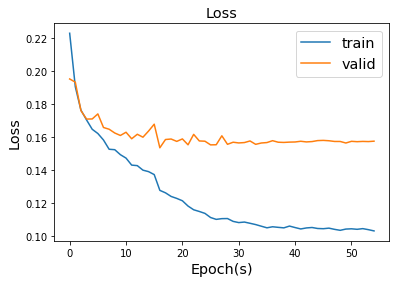

In [68]:
plt.clf()
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')

plt.title("Loss", fontsize='x-large')
plt.xlabel("Epoch(s)", fontsize='x-large')
plt.ylabel("Loss", fontsize='x-large')
plt.legend(fontsize='x-large')

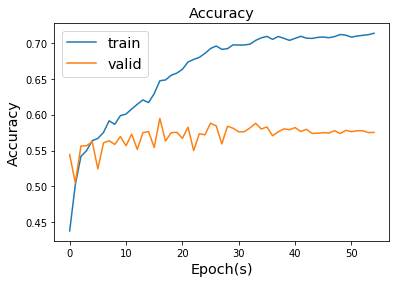

In [69]:
plt.clf()
plt.plot(train_acs, label='train')
plt.plot(valid_acs, label='valid')

plt.title("Accuracy", fontsize='x-large')
plt.xlabel("Epoch(s)", fontsize='x-large')
plt.ylabel("Accuracy", fontsize='x-large')
plt.legend(fontsize='x-large')

In [27]:
import pandas as pd

In [28]:
tmp = pd.read_csv("../hw4_data/TrimmedVideos/label/gt_valid.csv")

In [35]:
gt = np.array(tmp["Action_labels"].tolist())

In [45]:
pred = []
with open("./Task2/p2_valid.txt", 'r') as fd:
    for line in fd:
          pred.append(int(line.strip('\n ')))
    fd.close()
pred = np.array(pred)

In [46]:
(gt == pred).sum() / gt.shape[0]

0.47724317295188556

In [5]:
ac = 0.0
data_num = 0.0

for task in ["OP06-R03-BaconAndEggs.txt"]: #os.listdir("../hw4_data/FullLengthVideos/labels/valid/"):
    
    print(task)
    
    gt = []
    with open("../hw4_data/FullLengthVideos/labels/valid/" + task, 'r') as fd:
        for line in fd:
            tmp = line.strip('\n ')
            if tmp is not None:
                gt.append(int(tmp))
        fd.close()
    gt = np.array(gt)
    
    pred = []
    with open("./Task3/tmp/" + task, 'r') as fd:
        for line in fd:
            tmp = line.strip('\n ')
            if tmp is not None:
                pred.append(int(tmp))
        fd.close()
    pred = np.array(pred)
    
    ac += (pred == gt).sum()
    data_num += pred.shape[0]
    
    print((pred == gt).sum() / pred.shape[0])
    print("============")
    

OP06-R03-BaconAndEggs.txt
0.6718246292714378


In [7]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
gt

array([0, 0, 0, ..., 0, 0, 0])

<BarContainer object of 1551 artists>

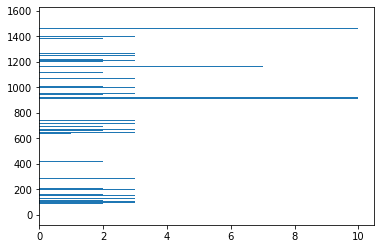

In [11]:
plt.clf()

plt.barh(np.arange(len(pred)), pred)

In [22]:
import seaborn as sns; sns.set()

In [50]:
data2plot = np.stack([pred, gt])[:,:500]

(0.0, 500.0, 1.5, 0.5)

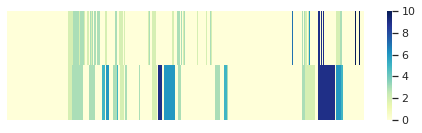

In [51]:
plt.figure(figsize=(8,2))
sns.heatmap(data2plot, cmap="YlGnBu")
# plt.yticks(np.arange(2), ["Pred", "Ground Truth"])
plt.axis('off')

In [6]:
ac / data_num

0.6718246292714378

In [52]:
img_dir = "../hw4_data/FullLengthVideos/videos/valid/OP06-R03-BaconAndEggs/"

In [54]:
img_fn = sorted(os.listdir(img_dir), key=lambda x:int(x.split('.')[0]))

In [55]:
imgs = []

for fn in img_fn:
    
    img = cv2.imread(img_dir + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    imgs.append(img)

In [57]:
imgs = imgs[:500]

In [58]:
imgs = np.stack(imgs)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sys

# from model import *
# from train import *
# from reader import *

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models

from tqdm import tqdm_notebook as tqdm


In [2]:
import numpy as np
import skvideo.io
import skimage.transform
import csv
import collections
import os

def readShortVideo(video_path, video_category, video_name, downsample_factor=12, rescale_factor=1):
    '''
    @param video_path: video directory
    @param video_category: video category (see csv files)
    @param video_name: video name (unique, see csv files)
    @param downsample_factor: number of frames between each sampled frame (e.g., downsample_factor = 12 equals 2fps)
    @param rescale_factor: float of scale factor (rescale the image if you want to reduce computations)

    @return: (T, H, W, 3) ndarray, T indicates total sampled frames, H and W is heights and widths
    '''

    filepath = video_path + '/' + video_category
    filename = [file for file in os.listdir(filepath) if file.startswith(video_name)]
    video = os.path.join(filepath,filename[0])

    videogen = skvideo.io.vreader(video)
    frames = []
    for frameIdx, frame in enumerate(videogen):
        if frameIdx % downsample_factor == 0:
            frame = skimage.transform.rescale(frame, rescale_factor, mode='constant', preserve_range=True, multichannel=True, anti_aliasing=True).astype(np.uint8)
            frames.append(frame)
        else:
            continue

    return np.array(frames).astype(np.uint8)


def getVideoList(data_path):
    '''
    @param data_path: ground-truth file path (csv files)

    @return: ordered dictionary of videos and labels {'Action_labels', 'Nouns', 'End_times', 'Start_times', 'Video_category', 'Video_index', 'Video_name'}
    '''
    result = {}

    with open (data_path) as f:
        reader = csv.DictReader(f)
        for row in reader:
            for column, value in row.items():
                result.setdefault(column,[]).append(value)

    od = collections.OrderedDict(sorted(result.items()))
    return od


In [3]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as trns

import os
import cv2
import torch
import numpy as np
import pandas as pd

MAX_LENGTH = 10

class TrimImageDataset(Dataset):

	def __init__(self, label_path, video_path):

		self.video_path = video_path
		self.label_path = label_path
		self.image_dict = getVideoList(label_path)

		self.mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 3)
		self.std = np.array([0.229, 0.224, 0.225]).reshape(-1, 3)

	def normalize(self, video):
		T, H, W, C = video.shape
		norm_video = (video.reshape(-1, C) - self.mean) / self.std
		return norm_video.reshape((T, H, W, C))


	def __getitem__(self, index):

		label = int(self.image_dict["Action_labels"][index])
		video_cat = self.image_dict["Video_category"][index]
		video_name = self.image_dict["Video_name"][index]
		
		video = readShortVideo(self.video_path, video_cat, video_name, downsample_factor=12, rescale_factor=1)
		norm_video = self.normalize(video.astype(np.float64) / 255.0).transpose((0, 3, 1, 2))

		#sample the middle 
		if norm_video.shape[0] > MAX_LENGTH:
			mid = norm_video.shape[0] // 2
			norm_video = norm_video[mid-5:mid+5]

		video_len = norm_video.shape[0]
		pad_len = MAX_LENGTH - video_len
		pad_emb = np.zeros( (pad_len, 3, 240, 320) )

		norm_video = np.concatenate((norm_video, pad_emb), axis=0)

		return norm_video, video_len, label

	def __len__(self):
		return len(self.image_dict["Video_index"])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import sys

import torchvision.models as models

class Model(nn.Module):

	def __init__(self, pretrain):
		super(Model, self).__init__()

		self.Feature_Extract = nn.Sequential(
			pretrain.conv1,
			pretrain.bn1,
			pretrain.relu,
			pretrain.maxpool,

			pretrain.layer1,
			pretrain.layer2,
			pretrain.layer3,
			pretrain.layer4,

			pretrain.avgpool
		)
		
		self.RedDim = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(16384, 256),
			nn.SELU(inplace=True),
		)

		self.encoder = nn.GRU(256, 256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)

		self.output_layer = nn.Sequential(
			nn.Linear(512, 256),
			nn.SELU(inplace=True),
			nn.Dropout(0.1),
			
			nn.Linear(256, 128),
			nn.SELU(inplace=True),
			nn.Dropout(0.1),

			nn.Linear(128, 11),
			nn.LogSoftmax(dim=1)
		)

	# (NxT, H, W)
	def extract(self, inp):
		with torch.no_grad():
			feat = self.Feature_Extract(inp).flatten(start_dim=1).detach()
		feat = self.RedDim(feat)
		return feat

	# (B, S, Emb Size)
	def encode(self, feat, inp_len):

		packed_emb = nn.utils.rnn.pack_padded_sequence(feat, inp_len, batch_first=True)
		output, hidden = self.encoder(packed_emb)

		cat_emb = hidden[-2:,:,:].permute(1,0,2).flatten(start_dim=1)
# 		out = self.output_layer(cat_emb)

		return cat_emb


In [5]:
def evaluate(model, valid_data):

    model = model.eval()

    trange = tqdm(valid_data)
    
    feat = []
    label = []
    
    with torch.no_grad():

        for data in trange:

            video_ten, video_len_ten, label_ten = data

            batch_size = video_ten.size(0)

            video_ten = video_ten.cuda().view(-1, 3, 240, 320)
            video_len_ten = video_len_ten.cuda()
            label_ten = label_ten.cuda()

            video_feat = model.extract(video_ten).view(batch_size, MAX_LENGTH, 256)

            cat_emb = model.encode(video_feat, video_len_ten)
            
            feat.append(cat_emb.cpu().numpy())
            label.append(label_ten.cpu().numpy())
            
    return feat, label

In [6]:
def collate_fn(data):

	video, video_len, video_label = zip(*data)
	
	video = np.stack(video)
	video_len = np.stack(video_len)
	video_label = np.stack(video_label)

	sort_idx = video_len.argsort(axis=0)[::-1]

	video = video[sort_idx]
	video_len = video_len[sort_idx]
	video_label = video_label[sort_idx]

	video_len_ten = torch.from_numpy(video_len).long()
	video_label_ten = torch.from_numpy(video_label).long()
	video_ten = torch.from_numpy(video).float()

	return video_ten, video_len_ten, video_label_ten

In [8]:
test_video_dir = "../hw4_data/TrimmedVideos/video/valid/"
test_label_path = "../hw4_data/TrimmedVideos/label/gt_valid.csv"

model_path = "../model/Task2/best_model_0.4850455136540962"

valid_dataset = TrimImageDataset(test_label_path, test_video_dir)
valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=16, num_workers=3, collate_fn=collate_fn)

pretrain = models.resnet50(pretrained=True)
model = Model(pretrain)

model.load_state_dict(torch.load(model_path))

model = model.cuda()

feat, label = evaluate(model, valid_dataloader)

/home/ck20jimmy/anaconda3/envs/DLCV_hw4/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [9]:
feat = np.concatenate(feat, axis=0)
label = np.concatenate(label, axis=0)

In [11]:
test_video_dir = "../hw4_data/TrimmedVideos/video/train/"
test_label_path = "../hw4_data/TrimmedVideos/label/gt_train.csv"

model_path = "../model/Task2/best_model_0.4850455136540962"

train_dataset = TrimImageDataset(test_label_path, test_video_dir)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=16, num_workers=3, collate_fn=collate_fn)

pretrain = models.resnet50(pretrained=True)
model = Model(pretrain)

model.load_state_dict(torch.load(model_path))

model = model.cuda()

train_feat, train_label = evaluate(model, train_dataloader)

/home/ck20jimmy/anaconda3/envs/DLCV_hw4/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [12]:
train_feat = np.concatenate(train_feat, axis=0)
train_label = np.concatenate(train_label, axis=0)

In [13]:
feat = np.concatenate((train_feat, feat), axis=0)
label = np.concatenate((train_label, label), axis=0)

In [14]:
from sklearn.manifold import TSNE

In [15]:
red_emb = TSNE(n_components=2).fit_transform(feat)

In [17]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

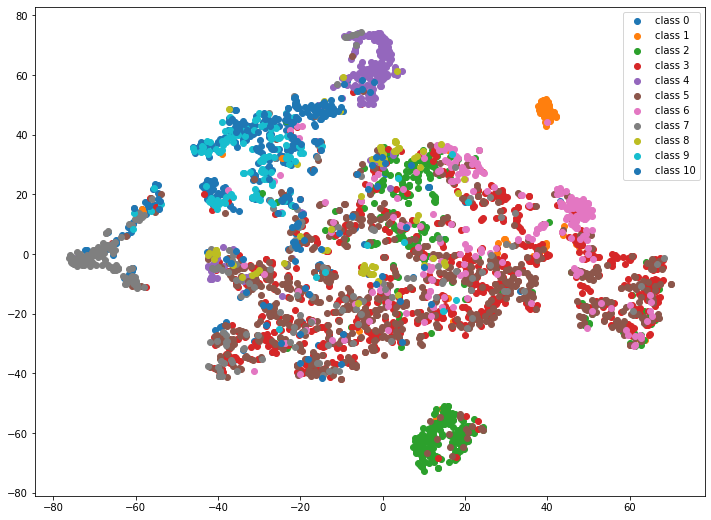

In [18]:
plt.clf()
plt.figure(figsize=(12, 9))

for i in range(11):
    data2plot = red_emb[label == i,:]
    plt.scatter(data2plot[:,0], data2plot[:,1], label='class '+str(i))
    
plt.legend()